# Solving the heat equation

In this notebook we will learn how to use tensorized linear solvers for solving a
partial differential equation (PDE). The PDE in question will be the heat equation
$\Delta x = b$. $\Delta$ is the laplace operator and $b$ some boundary condition.
We will solve the equation in question with finite difference on a two dimensional
grid.

In [1]:
import numpy as np
from trainsum.numpy import trainsum as ts
from trainsum.typing import UniformGrid
import matplotlib.pyplot as plt

def laplace(grid: UniformGrid, idx: int) -> ts.TensorTrain[NDArray]:
    """
    Get the tensor train which represents the finite difference
    laplace operator with the dimension defined by idx.
    """
    train = None
    with ts.exact():
        for i, dim in enumerate(grid.dims):
            if i == idx:
                tmp  = -2.0 * ts.shift(dim, 0)
                tmp +=  1.0 * ts.shift(dim, -1)
                tmp +=  1.0 * ts.shift(dim, 1)
                tmp *= -1/grid.spacings[0]**2
            else:
                tmp = ts.shift(dim, 0)
            if train is None:
                train = tmp
            else:
                train.extend(tmp)
    return train

As a first step we define the laplace operator as a tridiagonal toeplitz
matrix with -2 on the main diagonal and 1 on the diagonals above and below.

In [2]:
# define the domain on which the problem is solved
shape = ts.trainshape(32, 32, mode="block")
domains = ts.domain(0.0, 1.0), ts.domain(0.0, 1.0)
grid = ts.uniform_grid(shape.dims, domains)

xshape = ts.trainshape(shape.dims[0])
yshape = ts.trainshape(shape.dims[1])

Next we define solution space with an uniformly spaced grid. For doing so we will 
need some dimensions which are associated to some intervals (domains).

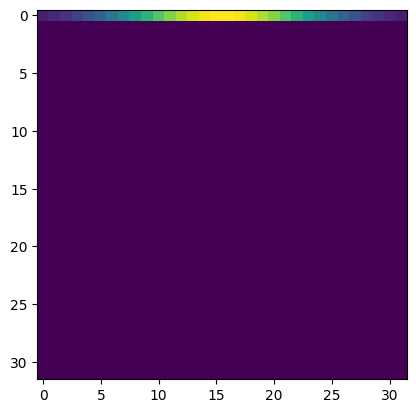

In [3]:
# create a tensor train, which has ones at one side else zeros
with ts.variational(max_rank=1):
    data = np.zeros(shape.dims[0].size())
    data[0] = 1.0
    rhs = ts.tensortrain(xshape, data)
    rhs.extend(ts.full(yshape, 1))

# multiply the train along the y-axis with a gauss-shapes function
with ts.variational(max_rank=10):
    y = np.linspace(domains[1].lower, domains[1].upper, shape.dims[1].size())
    data = np.exp(-10*(y-0.5)**2) # change this part to get another boundary condition
    #data =  (y-0.5)**2
    tmp = ts.tensortrain(yshape, data)
    rhs = ts.einsum("ab,b->ab", rhs, tmp)

# plot the resulting matrix
plt.figure()
plt.imshow(rhs.to_tensor())
plt.show()

In the next cell we define the boundary condition $b$. It is chosen so one site
of the square represents a gaussian shaped function.

In [4]:
# define the laplace operators
shape.ranks = 15
laplace_ops = [laplace(grid, i) for i in range(len(shape.dims))]
laplace_maps = [ts.linear_map("imjn,mn->ij", op, shape) for op in laplace_ops]

After defining the right hand side of the equation we will see how to define the linear
operators used to define the linear equation system. Since $\Delta$ is the sum of its $x$
and $y$ component, we can define it as two seperate operators $\Delta_x$ and $\Delta_y$.

In [5]:
# define the strategy and local solvers
strat = ts.sweeping_strategy(ncores=2, nsweeps=5)
decomp = ts.svdecomposition(max_rank=10, cutoff=1e-6)
solver = ts.gmres(nsteps=25, subspace=25, eps=1e-6)

# define the tensorized linear solver
lin_solver = ts.linsolver(
    rhs,
    *laplace_maps,
    method="dmrg",
    strategy=strat,
    decomposition=decomp,
    solver=solver)

At this step all components of the equation are defined and we can instantiate the solver.
For doing so we need a sweeping strategy, a decomposition (for strategies with ncores >= 2)
and a non tensorized solver for linear equation systems. Since it is very convenient to
implicitly define the local linear maps the library implements a GMRES solver.

In [6]:
# callback for printing and retrieval of local results
vals = []
def callback(lrange, res):
    print(f"{res.residuals[-1]:.8E}", end="\r", flush=True)
    vals.append(res.residuals[-1])
    return False

# create some start guess and solve the system
guess = ts.full(shape, 1)
res = lin_solver(guess, callback=callback)

7.08044032E-07

With the solver we can now start the process of solving the equation.

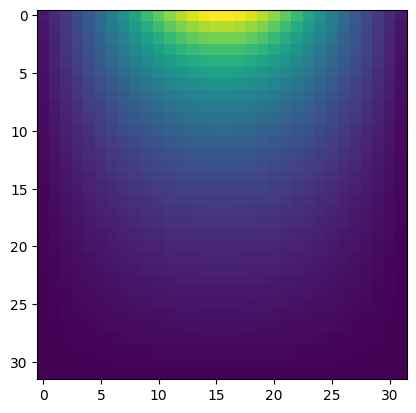

In [7]:
# plot the heat map
plt.figure()
plt.imshow(res.to_tensor())
plt.show()